<br />

### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

In [2]:
df = pd.read_csv("../data/fret_binding_curve.csv", comment = '#')
df

,buffer,fluorescence,a conc (nM),b conc (nM)
0,1256.5751,258316.2818,50.0,1500.000000
1,1256.5751,267722.6277,50.0,750.000000
2,1256.5751,267431.6620,50.0,375.000000
3,1256.5751,284596.2914,50.0,187.500000
4,1256.5751,254903.3958,50.0,93.750000
5,1256.5751,333810.6371,50.0,46.875000
6,1256.5751,370821.7778,50.0,23.437500
7,1256.5751,408856.1424,50.0,11.718750
8,1256.5751,431000.0000,50.0,5.859375
9,1256.5751,437000.0000,50.0,0.000000


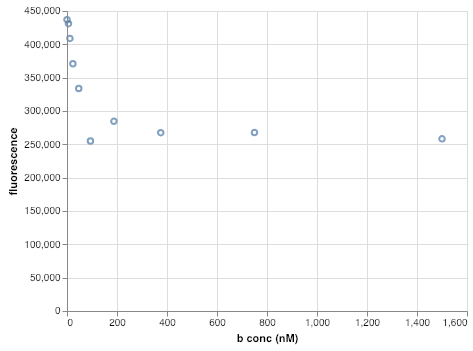

In [3]:
alt.Chart(df).mark_point().encode(
    x = alt.X("b conc (nM)"),
    y = alt.Y("fluorescence"))

LOL I wonder if there are any outliers

Given our known quantities and our goal, the relevant equation is:
\begin{align}
F
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The concentration of a is a set quantity in this experiment and that of b is our independent variabl, so we need parameter estimates of $K_d$, $\hat{f}_0$, and $\hat{f}_q$. Additionally we want to include a Gaussian error term $\sigma$ to reflect errors in measurement. Our priors are as follows:

$$\text{fl} = \text{Norm}(F(c_a^0), \sigma).$$ 

In [4]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

$K_d$ ~ lognorm(1, 3) Given our (limited) knowledge of dissociation constants, we expect $K_d$ to be very small, but do no know the order of magnitude, so we will use a log-normal distribution

$\hat{f}_0$ ~ Norm(10000, 1000) Flourescence is an ununited relative value, but in this experiment it appears to be between 100000 and 500000. Since $F= \hat{f}_0\,c_a^0$, we expect the highest fluorescence value to be $50*\hat{f}_0$ so we will choose a distribution with a wide variation at the top of this scale

$\hat{f}_q$ ~ Norm(1000,100) We expect quenched molecules to have a much smaller fluorescence than the unquenched molecules, so we will choose a distribution an order of magnitude smaller than that of $\hat{f}_0$

$\sigma$ ~ Half-Norm(0, .5): We expect a variability in measurement of about .1, and to vary from that by about .1. 

Additionally, we know that 
$c_a^0$ = 50 nM

In [5]:
sm = bebi103.stan.StanModel(file='./9.2_prior.stan')

Using cached StanModel.


In [6]:
samples = sm.sampling(data=data, algorithm="Fixed_param",
                          warmup=0,
                          chains=1,
                          iter=1000)

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [7]:
df_gen = bebi103.stan.to_dataframe(samples, diagnostics=False)
df_gen

,chain,chain_idx,warmup,Kd,f0,fq,sigma,ca,F[1],F[2],...,likelihood[2],likelihood[3],likelihood[4],likelihood[5],likelihood[6],likelihood[7],likelihood[8],likelihood[9],likelihood[10],lp__
0,1,1,0,812.907420,11588.723066,1082.338691,2933.787979,50.0,241353.540882,331536.850104,...,335915.705478,414833.663544,490720.289892,526863.844600,558594.105655,567705.463391,571747.232509,577560.372617,582757.831653,0.0
1,1,2,0,0.020614,10321.311745,1207.601298,5046.690916,50.0,60386.543095,60393.483798,...,57958.933307,65363.976941,64548.502331,66061.545240,98348.204340,297730.166504,408678.190115,469973.538083,516486.331043,0.0
2,1,3,0,0.006864,9529.900249,1118.692094,2503.483209,50.0,55936.595456,55938.728379,...,51709.956383,52643.057250,55392.375477,57444.754631,80420.232158,281350.084332,380907.537812,428592.096472,477735.852910,0.0
3,1,4,0,31.415367,10378.063130,951.590421,1812.123836,50.0,57567.416710,67764.471220,...,64883.442327,88506.832082,125217.918032,207151.383362,310154.299268,401320.808255,455589.103186,484525.658669,523020.887195,0.0
4,1,5,0,1.167853,9907.390905,985.644415,10530.350983,50.0,49641.207519,50025.127925,...,47895.209424,67934.456887,64833.393896,44428.552620,132598.792968,285626.404403,390063.249274,464141.621752,516767.987173,0.0
5,1,6,0,0.302038,11782.106468,1077.100866,1947.431938,50.0,53966.513076,54085.888025,...,53420.033422,57271.189038,56139.771284,57013.189308,111017.437853,340617.876018,462404.692087,525833.067538,591203.944902,0.0
6,1,7,0,79.047105,7308.117946,1098.422431,6150.697236,50.0,70945.201265,86222.364098,...,91400.980478,116031.441001,153863.510711,220175.716096,279241.664961,313101.164093,338614.982181,348992.264100,364850.194953,0.0
7,1,8,0,1.081931,11061.875164,1028.657466,7368.561530,50.0,51806.903405,52206.966197,...,47922.110455,72071.791263,57614.469633,65796.728833,130637.424653,324872.458966,430541.034438,482102.778239,556774.357522,0.0
8,1,9,0,3.021854,9360.706600,927.926681,7098.123051,50.0,47273.155238,48208.144370,...,55052.319101,42498.335357,47552.192493,65082.068051,144007.519457,294800.400055,365674.945356,417228.474555,476132.567233,0.0
9,1,10,0,274.077245,9592.859185,1087.686693,5342.832933,50.0,121679.035474,172359.855075,...,183845.902792,240950.771484,312664.524730,387496.177021,430571.281204,451323.974662,463690.877793,475160.934414,475189.639779,0.0


In [8]:
cols = ["likelihood[1]", "likelihood[2]", "likelihood[3]", "likelihood[4]", "likelihood[5]",
        "likelihood[6]", "likelihood[7]", "likelihood[8]", "likelihood[9]", "likelihood[10]"]

In [9]:
data

{'N': 10,
 'cb': array([1500.      ,  750.      ,  375.      ,  187.5     ,   93.75    ,
          46.875   ,   23.4375  ,   11.71875 ,    5.859375,    0.      ])}

In [10]:
df_gen_fl = df_gen[cols]
df_gen_fl = df_gen_fl.stack(level=0)
df_gen_fl = df_gen_fl.reset_index()
df_gen_fl = df_gen_fl.sort_index(level=1)


# Renaming the columns with useful names
df_gen_fl = df_gen_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

# Renaming the conditions with more descriptive names
for i in range(len(cols)):
    df_gen_fl = df_gen_fl.replace({cols[i]:data['cb'][i]})
    



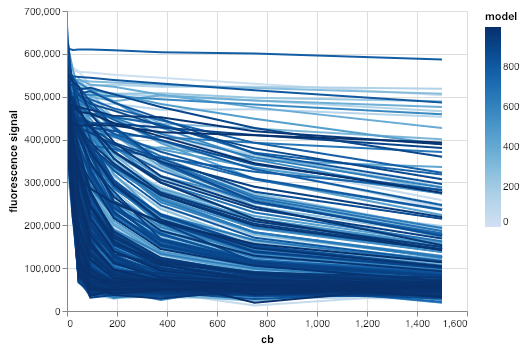

In [11]:
alt.Chart(df_gen_fl).mark_line().encode(
    x = alt.X('cb'),
    y = alt.Y('fluorescence signal'),
    color = alt.Color('model')).interactive()
    

In [12]:
sm2 = bebi103.stan.StanModel(file='./9.2_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b34c679b2ce399e775db4e3803f1f9fb NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmp9bc10l0b/stanfit4anon_model_b34c679b2ce399e775db4e3803f1f9fb_7648907505958072706.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [13]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

In [14]:
samples2 = sm2.sampling(data=data)

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [15]:
df2 = bebi103.stan.to_dataframe(samples2, diagnostics=False, inc_warmup=False)

In [16]:
df2.tail()

,chain,chain_idx,warmup,Kd,f0,fq,sigma,fl[1],fl[2],fl[3],...,fl_ppc[2],fl_ppc[3],fl_ppc[4],fl_ppc[5],fl_ppc[6],fl_ppc[7],fl_ppc[8],fl_ppc[9],fl_ppc[10],lp__
3995,4,996,0,0.114456,-26.915582,12.266836,1404.741437,1096.852982,1489.662931,1522.593767,...,1004.434203,1045.890091,-1588.666649,-419.600591,-1286.332552,2072.676242,-2449.644302,-115.899359,-2684.752163,-167.094095
3996,4,997,0,0.284889,-26.848653,12.282521,1398.095592,1094.596288,1491.589746,1527.042555,...,348.653637,417.767751,-1146.718293,-169.498576,-373.692599,-707.697530,-2345.053917,-480.300244,214.689227,-167.728991
3997,4,998,0,0.274624,-26.835645,12.260305,1378.544431,1094.705572,1492.520497,1527.288464,...,27.371623,-198.064387,2208.375869,1379.220903,-2543.253517,521.642201,-2989.303494,-1889.613649,-1289.340644,-167.676560
3998,4,999,0,0.269045,-26.919662,12.288281,1365.029663,1096.563798,1492.265502,1529.271068,...,1677.976540,388.450173,358.960964,-520.537895,-905.069677,93.828953,-1267.455387,78.838955,-1764.626493,-167.657265
3999,4,1000,0,0.280009,-26.962599,12.431404,1375.130276,1094.439453,1493.197354,1523.821336,...,-1239.807898,683.418213,1258.425449,2491.869914,-868.892634,-2823.246498,178.845693,-2770.312159,-3055.006373,-167.677653
